In [0]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [0]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        # read all text
        text = file.read()
        file.close()
        return text

# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      return sents

In [0]:
#read eng data
eng_data = read_text("eng.txt")
eng = to_lines(eng_data)
eng = array(eng)
eng = eng[:7000]

#read french data
frn_data = read_text("frn.txt")
frn = to_lines(frn_data)
frn = array(frn)
frn = frn[:7000]

In [0]:
#remove punctuation
eng[:] = [s.translate(str.maketrans('', '', string.punctuation)) for s in eng[:]]
frn[:] = [s.translate(str.maketrans('', '', string.punctuation)) for s in frn[:]]


In [0]:
# convert text to lowercase
for i in range(len(eng)):
    eng[i] = eng[i].lower()
    frn[i] = frn[i].lower()

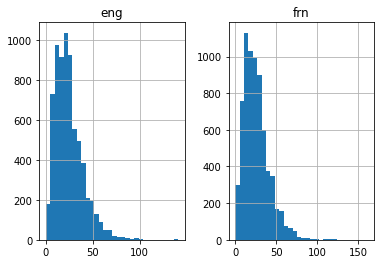

In [10]:
# empty lists
eng_l = []
frn_l = []

# populate the lists with sentence lengths
for i in eng:
      eng_l.append(len(i.split()))

for i in frn:
      frn_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'frn':frn_l})

length_df.hist(bins = 30)
plt.show()

In [0]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [0]:
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

In [32]:
# prepare english tokenizer
eng_tokenizer = tokenization(eng[:])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 70 #max_length(eng[:])
print('English Vocabulary Size: %d' % eng_vocab_size)
print("English max length: %d" % eng_length)

# prepare french tokenizer
frn_tokenizer = tokenization(frn[:])
frn_vocab_size = len(frn_tokenizer.word_index) + 1
frn_length = 70# max_length(frn[:])
print('French Vocabulary Size: %d' % frn_vocab_size)
print("French max length: %d" %frn_length)

English Vocabulary Size: 9195
English max length: 70
French Vocabulary Size: 13126
French max length: 70


In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [0]:
# split data into train and test set
train_eng, test_eng = train_test_split(eng, test_size=0.3, random_state = 12)
train_frn, test_frn = train_test_split(frn, test_size=0.3, random_state = 12)

In [0]:
# prepare training data
trainX = encode_sequences(eng_tokenizer, eng_length, train_eng)
trainY = encode_sequences(frn_tokenizer, frn_length, train_frn)

# prepare validation data
testX = encode_sequences(eng_tokenizer, eng_length, train_eng)
testY = encode_sequences(frn_tokenizer, frn_length, train_frn)

In [0]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [0]:
# model compilation
model = define_model(eng_vocab_size, frn_vocab_size, eng_length, frn_length, 512)

In [0]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [50]:
filename = 'model1.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=40, batch_size=512, validation_split = 0.3,callbacks=[checkpoint], 
                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3430 samples, validate on 1470 samples
Epoch 1/40
3430/3430 [==============================] - 7s 2ms/step - loss: 5.8465 - val_loss: 3.1407

Epoch 00001: val_loss improved from inf to 3.14066, saving model to model1.h5
Epoch 2/40
3430/3430 [==============================] - 7s 2ms/step - loss: 3.1102 - val_loss: 3.0933

Epoch 00002: val_loss improved from 3.14066 to 3.09330, saving model to model1.h5
Epoch 3/40
3430/3430 [==============================] - 6s 2ms/step - loss: 3.0689 - val_loss: 3.1069

Epoch 00003: val_loss did not improve from 3.09330
Epoch 4/40
3430/3430 [==============================] - 6s 2ms/step - loss: 3.0236 - val_loss: 2.9758

Epoch 00004: val_loss improved from 3.09330 to 2.97582, saving model to model1.h5
Epoch 5/40
3430/3430 [==============================] - 7s 2ms/step - loss: 3.0135 - val_loss: 2.9334

Epoch 00005: val_loss improved from 2.97582 to 2.93340, saving model to model1.h5
Epoch 6/40
3430/3430 [==============================] - 6s 2ms

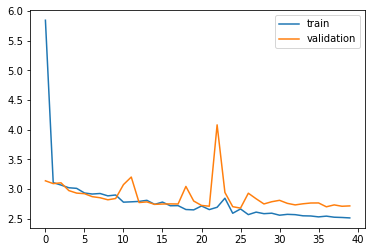

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [52]:
model = load_model('model1.h5')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [57]:
preds_text = []
for i in preds[0:10]:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], frn_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], frn_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))
       print(preds_text)

['je le                                                                    ']
['je le                                                                    ', 'je                                                                     ']
['je le                                                                    ', 'je                                                                     ', 'je le de                                                                   ']
['je le                                                                    ', 'je                                                                     ', 'je le de                                                                   ', 'je le de                                                                   ']
['je le                                                                    ', 'je                                                                     ', 'je le de                                                                

In [0]:
pred_df = pd.DataFrame({'actual' : test_eng[:], 'predicted' : preds_text})
pred_df.sample(15)